### Figures of spatial variation in continental vs. glacial river contributions 

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import os
from itertools import compress
import datetime as dt
from datetime import date
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from math import sin, cos, sqrt, atan2, radians
import warnings
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
warnings.filterwarnings('ignore')
import glob
from IPython.display import Image

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Parameters:

In [51]:
# Domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref = '/data/brogalla/run_storage/Mn-set4-202004/'
folder_riv = '/data/brogalla/run_storage/riv-2a-202005/'
folder_con = '/data/brogalla/run_storage/riv-2b-202005/'

# Time series folders:
folder_ts_ref   = '/ocean/brogalla/GEOTRACES/time-series/Mn-set4-202004/'
folder_ts_riv2a = '/ocean/brogalla/GEOTRACES/time-series/riv-2a-202005/'
folder_ts_riv2b = '/ocean/brogalla/GEOTRACES/time-series/riv-2b-202005/'

# Boundary coordinates:
l1i = 2013-imin;                      l1j = np.arange(300-jmin,392-jmin)
l2i = 1935-imin;                      l2j = np.arange(450-jmin,530-jmin)
l3i = np.arange(1850-imin,1885-imin); l3j = 555-jmin
l4i = np.arange(1753-imin,1837-imin); l4j = 568-jmin
l5i = np.arange(1720-imin,1790-imin); l5j = 605-jmin
l6i = 1730-imin;                      l6j = np.arange(660-jmin,690-jmin)
t1i = np.arange(1635-imin,1653-imin); t1j = 760-jmin
r1i = 1520-imin;                      r1j = np.arange(505-jmin,673-jmin)
r2i = 1520-imin;                      r2j = np.arange(385-jmin,405-jmin)
N1i = np.arange(1570-imin,1630-imin); N1j = 635-jmin #Nares
P1i = 1585-imin;                      P1j = np.arange(485-jmin,538-jmin)  #Parry channel
P1j = P1j[10:-5]; N1i = N1i[11:-8]

# Color map:
N = 256
# vals_cont = np.ones((N, 4))
# vals_cont[:, 0] = np.linspace(164/N, 1, N)
# vals_cont[:, 1] = np.linspace(116/N, 1, N)
# vals_cont[:, 2] = np.linspace(84/N, 1, N)
# cont_cmap = ListedColormap(vals_cont).reversed()

# vals_glac = np.ones((N, 4))
# vals_glac[:, 0] = np.linspace(113/N, 1, N)
# vals_glac[:, 1] = np.linspace(169/N, 1, N)
# vals_glac[:, 2] = np.linspace(144/N, 1, N)
# glac_cmap = ListedColormap(vals_glac).reversed()

# vals_both = np.ones((N, 4))
# vals_both[:, 0] = np.linspace(89/N, 1, N); 
# vals_both[:, 1] = np.linspace(89/N, 1, N)
# vals_both[:, 2] = np.linspace(89/N, 1, N)
# both_cmap = ListedColormap(vals_both).reversed()

# #d67434 #ab5c29
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

# #32ab90 #0873b4
vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

land_color = '#a9a7a2'

##### Load files:

In [5]:
# Meshmasks
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]

mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])

In [6]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-2002/ANHA12_EXH006_2002_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

##### Functions:

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [7]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    diff_rivers = dmn_riv_on - dmn_riv_off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(diff_rivers, dmn_riv_off)
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

In [8]:
def load_river_results(year):
    file = 'ANHA12_EXH006_'+str(year)+'_monthly.nc'
    
    base_monthly = nc.Dataset(folder_ref+'ref-'+str(year)+'/'+file)
    glac_monthly = nc.Dataset(folder_riv+'riv-2a-'+str(year)+'/'+file)
    cont_monthly = nc.Dataset(folder_con+'riv-2b-'+str(year)+'/'+file)
    
    dmn_base = np.array(base_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_glac = np.array(glac_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_cont = np.array(cont_monthly.variables['dissolmn'])[:,0,:,:,:]
    
    return dmn_base, dmn_glac, dmn_cont

# Mackenzie river analysis

Fichot et al. (2013): "A progressive switch from eastward to northwestward routing occurred between 2002 and 2011  and coincides with the rapid freshening of the Canada Basin." 

In [9]:
def load_5d_results(file_ref, file_cont):    
    base = nc.Dataset(file_ref)
    cont = nc.Dataset(file_cont)
    
    dmn_base = np.array(base.variables['dissolmn'])[0,:,:,:]
    dmn_cont = np.array(cont.variables['dissolmn'])[0,:,:,:]
    
    return dmn_base, dmn_cont

In [10]:
def load_wind_results(year, Mackenzie=False):
    folder = '/data/brogalla/ANHA12/atmospheric_forcing/'
    fileu  = 'u10_gdps_y'+str(year)+'.nc'
    filev  = 'v10_gdps_y'+str(year)+'.nc'
    
    uyear  = nc.Dataset(folder+fileu)
    vyear  = nc.Dataset(folder+filev)
    
    u_wind = np.array(uyear.variables['u_wind'])
    v_wind = np.array(vyear.variables['v_wind'])
    lons = np.array(uyear.variables['LON'])
    lons = [lon-360 if (lon > 180) else lon for lon in lons] 
    lats = np.array(uyear.variables['LAT'])
    
    if Mackenzie:
        # find subset indices for the Mackenzie river:
        i=0; n=0;
        for lat in lats:
            if (lat > 65) & (i==0):
                min_lat = n
                i+=1
            elif (lat < 78) & (i==1):
                max_lat = n
            n+=1

        i=0; n=0;
        for lon in lons:
            if (lon < -160) & (lon > -161) & (i==0):
                min_lon = n
                i+=1
            elif (lon < -100) & (lon > -101) & (i==1):
                max_lon = n
            n+=1    

        wind_lons = lons[min_lon:max_lon]
        wind_lats = lats[min_lat:max_lat]

        uwind = u_wind[:,min_lat:max_lat,min_lon:max_lon]
        vwind = v_wind[:,min_lat:max_lat,min_lon:max_lon]
        return uwind, vwind, wind_lons, wind_lats
    else:
        return u_wind, v_wind, lons, lats

In [11]:
def look_river_data(start_date, end_date):
    
    files_list_ref  = np.sort(glob.glob('/data/brogalla/run_storage/Mn-set4-202004/ref-'+str(start_date.year)+\
                                        '/ANHA12_EXH006_5d_'+str(start_date.year)+'0101_'+\
                                        str(start_date.year)+'1231_ptrc_T_*'))
    files_list_cont = np.sort(glob.glob('/data/brogalla/run_storage/riv-2b-202005/riv-2b-'+str(start_date.year)+\
                                        '/ANHA12_EXH006_5d_'+str(start_date.year)+'0101_'+\
                                        str(start_date.year)+'1231_ptrc_T_*'))
    
    files_ref_start = [dt.datetime.strptime(i[93:101], "%Y%m%d") for i in files_list_ref]
    files_ref_end   = [dt.datetime.strptime(i[102:110], "%Y%m%d") for i in files_list_ref]
    files_ref       = list(compress(files_list_ref, [V > start_date and V < end_date for V in files_ref_start]))

    files_cont_start = [dt.datetime.strptime(i[95:103], "%Y%m%d") for i in files_list_cont]
    files_cont_end   = [dt.datetime.strptime(i[104:112], "%Y%m%d") for i in files_list_cont]
    files_cont       = list(compress(files_list_cont, [V > start_date and V < end_date for V in files_cont_start]))
    
    continental_contribution=np.empty((len(files_ref),isize,jsize))

    for i in range(0,len(files_ref)):
        base, cont = load_5d_results(files_ref[i], files_cont[i])
        continental_contribution[i,:,:] = np.nanmean(np.divide(cont - base, base)[0:10,:,:], axis=0)
    
    return files_ref, files_cont, continental_contribution

In [12]:
def look_wind_data(start_date, end_date):
    
    uwind, vwind, wind_lons, wind_lats = load_wind_results(start_date.year, Mackenzie=True)
    
    hourly_dates = [dt.datetime(start_date.year,1,1)+dt.timedelta(hours=i) for i in range(1,365*24+1)]

    # index of start date and end date within the hourly dates of the wind data:
    start_hindex = (start_date - dt.datetime(start_date.year,1,1)).days*24
    end_hindex   = (end_date - dt.datetime(start_date.year,1,1)).days*24

    # dates during which I look at tracer concentrations as well:
    overlap_dates = hourly_dates[start_hindex:end_hindex]
    overlap_uwind = uwind[start_hindex:end_hindex,:,:]
    overlap_vwind = vwind[start_hindex:end_hindex,:,:]
    
    return overlap_dates, overlap_uwind, overlap_vwind, wind_lons, wind_lats

In [65]:
def plot_5d_mackenzie(ax, fday, time, files_ref, overlap_dates, overlap_uwind, overlap_vwind, wind=False, lw=0, \
                     set_lw=False):

    proj2 = Basemap(projection='stere',lat_0 = 71, lon_0 = -135, resolution='i', width=1.5e6, height=1.0e6, ax=ax)
    
    x_land, y_land = proj2(lon, lat)
#     proj2.contourf(x_land[:,:], y_land[:,:], land_mask[10,:,:], \
#                    cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2)
    proj2.drawcoastlines(color='#373736', linewidth=1.8)
    proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    proj2.drawparallels(np.arange(int(60),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=10)
    proj2.drawmeridians(np.arange(int(-150),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=10)

    #--------------------- five day surface continental runoff field------------------------------
    x_model, y_model = proj2(lons, lats)

    CS2 = proj2.contourf(x_model, y_model, fday, \
                         20, cmap=cont_cmap, vmin=0.01, vmax=0.15, extend='both')
#                          20, cmap=cmocean.cm.dense, vmin=0.01, vmax=0.15, extend='both')

#     # Contour lines: 
#     proj2.contour(x_model, y_model, fday, levels=np.arange(0.00, 0.14, 0.06), \
#                          vmin=0.01, vmax=0.15, colors='#624532')#'#ab5c29')

    ax.set_title(files_ref[time][93:97]+'-'+files_ref[time][97:99]+'-'+files_ref[time][99:101]+' to '\
                 +files_ref[time][102:106]+'-'+files_ref[time][106:108]+'-'+files_ref[time][108:110])

    #--------------------- wind stream plot ------------------------------------------------------
    if wind:
        startt = np.datetime64(dt.datetime.strptime(files_ref[time][93:101],  '%Y%m%d'))
        endt   = np.datetime64(dt.datetime.strptime(files_ref[time][102:110], '%Y%m%d'))
        
        time_ind = np.array(np.where((overlap_dates > startt) & (overlap_dates < endt)))[0]
        
        u_1h_wind = np.zeros(overlap_uwind[0,:,:].shape); v_1h_wind=np.zeros(overlap_vwind[0,:,:].shape);
        for t in time_ind:
            u_1h_wind = np.add(overlap_uwind[t,:,:], u_1h_wind)
            v_1h_wind = np.add(overlap_vwind[t,:,:], v_1h_wind)
            
        u_5d_wind = u_1h_wind/len(time_ind)
        v_5d_wind = v_1h_wind/len(time_ind)
        
        speed = np.sqrt(u_5d_wind**2 + v_5d_wind**2)
        
        wlons, wlats   = np.meshgrid(wind_lons, wind_lats)
        x_wind, y_wind = proj2(wlons, wlats)
        
        # Streamline thickness is related to speed and set during the first time period, so that it is
        # the same for all plots
        if time==0:
            lw = 4*speed / speed.max()
        elif set_lw:
            lw = 6*speed / speed.max()
        
        ax.streamplot(x_wind[0,:], y_wind[:,0], u_5d_wind, v_5d_wind, \
                      arrowsize=2.5, density=1, color='#323232', linewidth=lw, arrowstyle='->')
#         ax.quiver(x_wind[0,:], y_wind[:,0], u_5d_wind, v_5d_wind, color='w')


    proj2.drawmapscale(-147, 67.5, -140, 75, 400, barstyle='fancy', zorder=5, fontsize=12)
    return lw

In [14]:
#start_date and end_date are datetime objects
start_date_20093 = dt.datetime(2009,2,10) # from 2008-10-22 onwards the plume is set up to go towards the east
end_date_20093   = dt.datetime(2009,7,30)

files_ref_20093, files_cont_20093, continental_contribution_20093  \
                                                                = look_river_data(start_date_20093, end_date_20093)
overlap_dates_20093, overlap_uwind_20093, overlap_vwind_20093, \
                                           wind_lons, wind_lats = look_wind_data(start_date_20093, end_date_20093)

# ignore areas with less than 1% of continental river contribution to dMn
continental_contribution_masked_20093 = np.ma.masked_where((continental_contribution_20093 < 0.01), \
                                                            continental_contribution_20093)

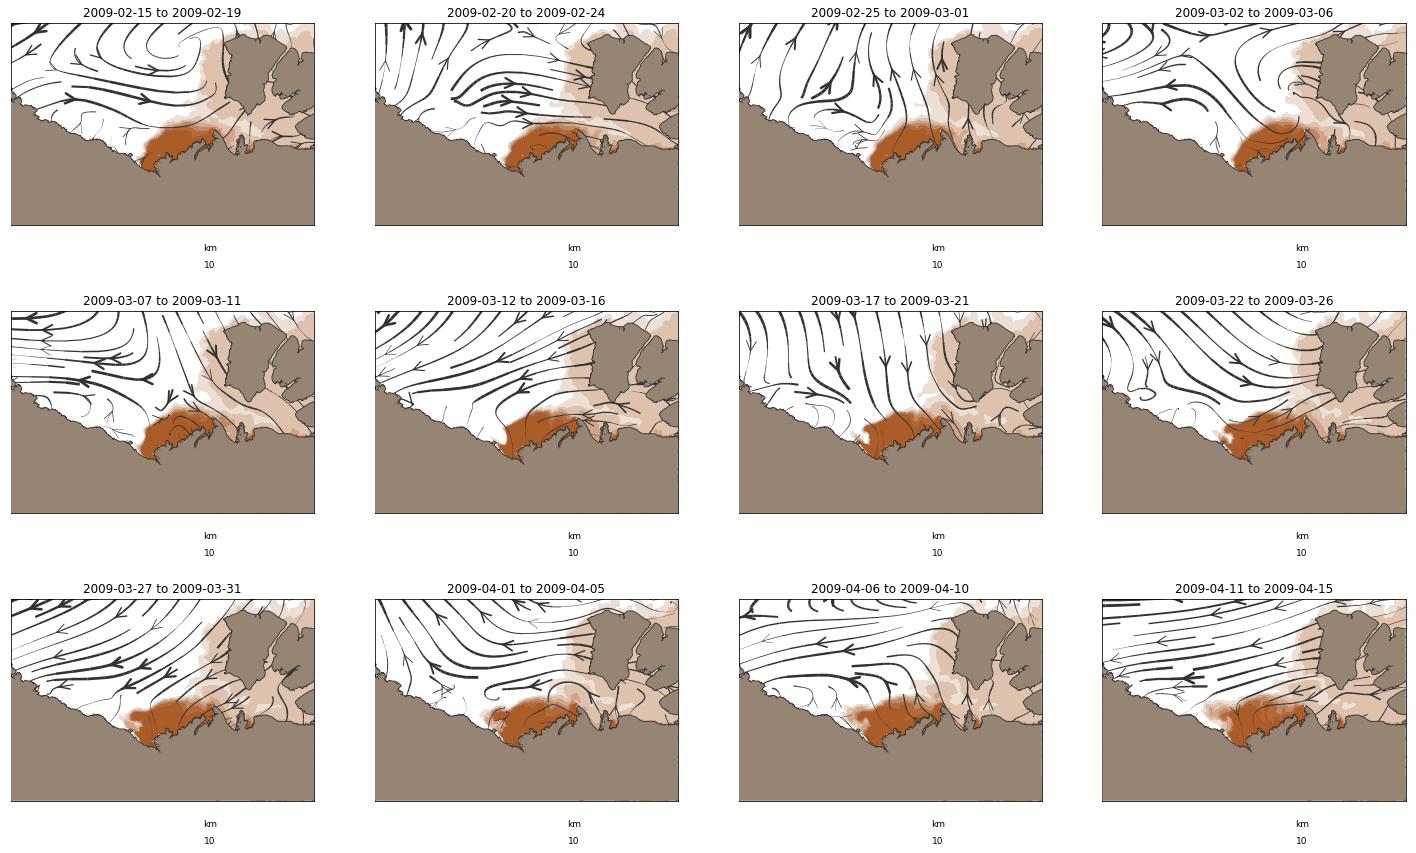

In [21]:
fig, ax = plt.subplots(3,4, figsize=(25,15))

lw=0; time=0; # number of 5day files in time period
for column in [0,1,2]:
    for axis in ax[column,:]:
        lw = plot_5d_mackenzie(axis, continental_contribution_masked_20093[time,:,:], \
                               time, files_ref_20093, overlap_dates_20093, overlap_uwind_20093, \
                               overlap_vwind_20093, wind=True, lw=lw)
            
        time+=1
        
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R4-mackenzie.png', bbox_inches='tight', dpi=300)

Show "20090215-2090219" or "20090220-20090224" for eastward prevailing wind and "20090411-20090415" or "20090401-20090405" for westward.

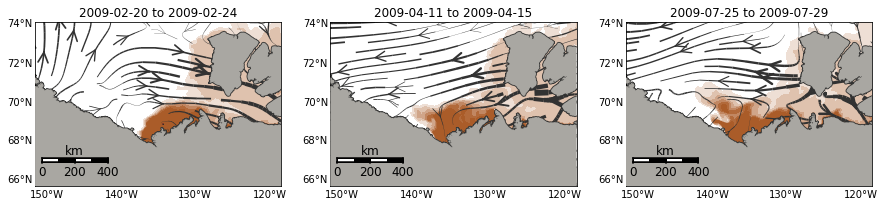

In [69]:
fig, ax = plt.subplots(1,3, figsize=(15,10))

time1 = 1
lw1 = plot_5d_mackenzie(ax[0], continental_contribution_masked_20093[time1,:,:], \
                        time1, files_ref_20093, overlap_dates_20093, overlap_uwind_20093, \
                        overlap_vwind_20093, wind=True, set_lw=True)

time2 = 11
lw2 = plot_5d_mackenzie(ax[1], continental_contribution_masked_20093[time2,:,:], \
                        time2, files_ref_20093, overlap_dates_20093, overlap_uwind_20093, \
                        overlap_vwind_20093, wind=True, lw=lw1)

time3 = 32
lw3 = plot_5d_mackenzie(ax[2], continental_contribution_masked_20093[time3,:,:], \
                        time3, files_ref_20093, overlap_dates_20093, overlap_uwind_20093, \
                        overlap_vwind_20093, wind=True, lw=lw2)
        
fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R2-Mackenzie.png', bbox_inches='tight', dpi=300)

In [125]:
#start_date and end_date are datetime objects
start_date_20095 = dt.datetime(2009,5,1) # from 2008-10-22 onwards the plume is set up to go towards the east
end_date_20095   = dt.datetime(2009,7,4)

files_ref_20095, files_cont_20095, continental_contribution_20095  \
                                                                = look_river_data(start_date_20095, end_date_20095)
overlap_dates_20095, overlap_uwind_20095, overlap_vwind_20095, \
                                           wind_lons, wind_lats = look_wind_data(start_date_20095, end_date_20095)

# ignore areas with less than 1% of continental river contribution to dMn
continental_contribution_masked_20095 = np.ma.masked_where((continental_contribution_20095 < 0.01), \
                                                            continental_contribution_20095)

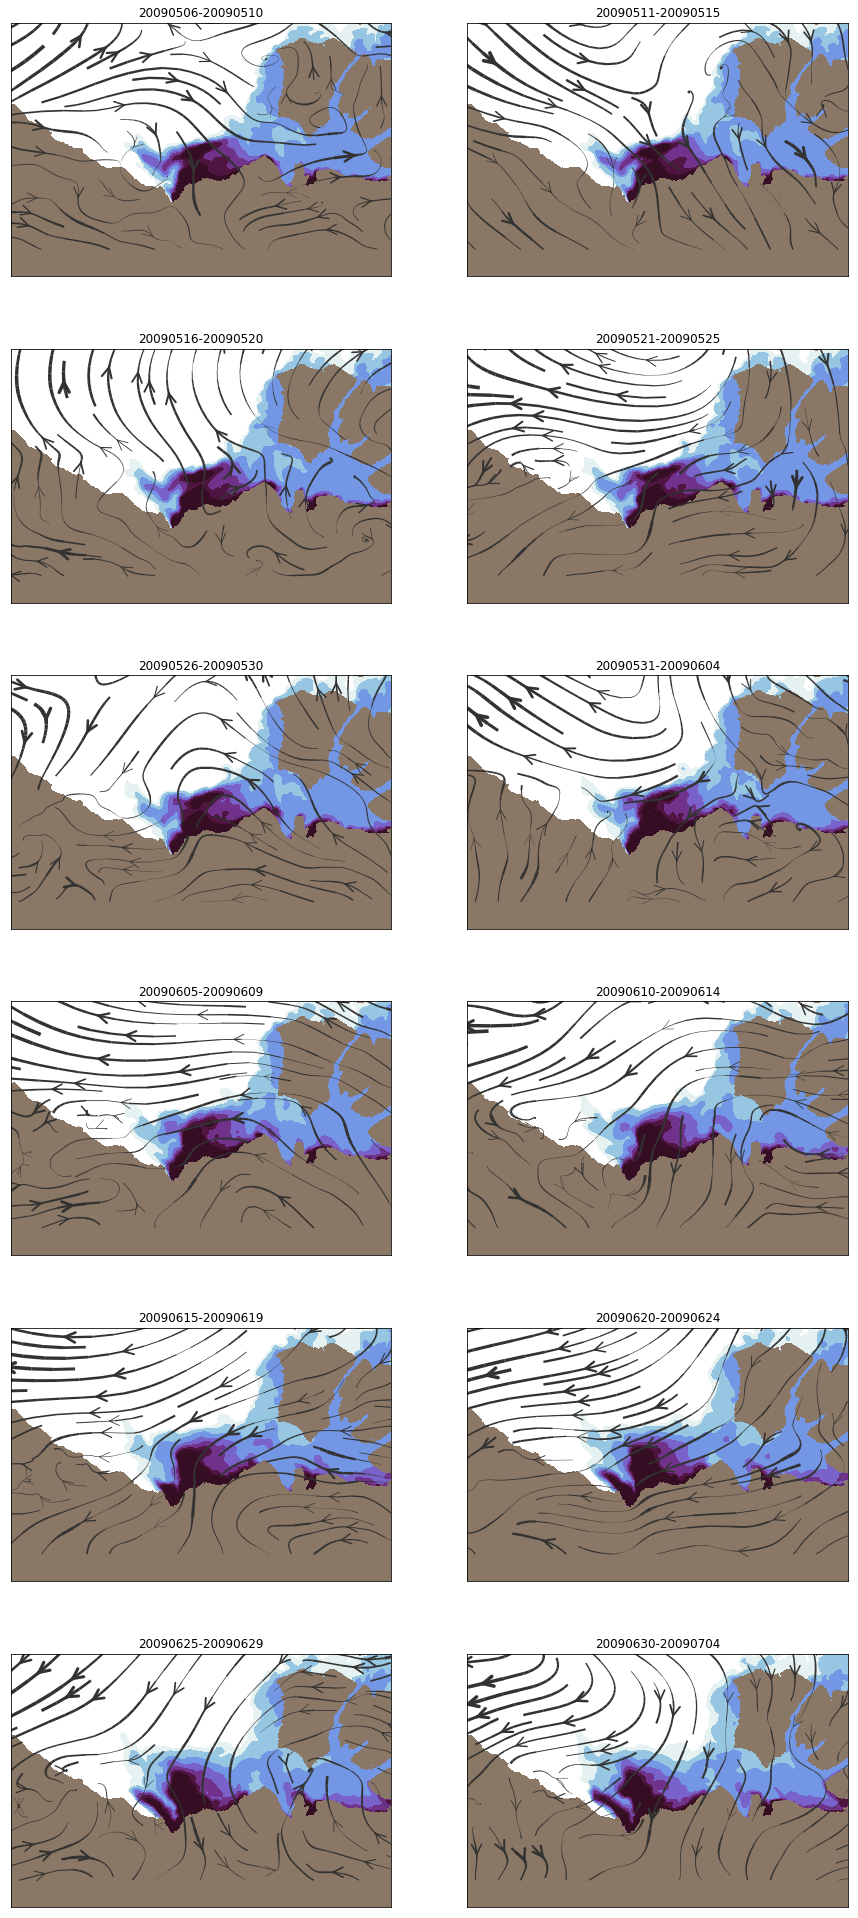

In [126]:
fig, ax = plt.subplots(6,2, figsize=(15,35))

lw=0; time=0; # number of 5day files in time period
for column in [0,1,2,3,4,5]:
    for axis in ax[column,:]:
        lw = plot_5d_mackenzie(axis, continental_contribution_masked_20095[time,:,:], \
                               time, files_ref_20095, overlap_dates_20095, overlap_uwind_20095, \
                               overlap_vwind_20095, wind=True, lw=lw)
            
        time+=1

In [130]:
#start_date and end_date are datetime objects
start_date_20097 = dt.datetime(2009,7,1) # from 2008-10-22 onwards the plume is set up to go towards the east
end_date_20097   = dt.datetime(2009,9,4)

files_ref_20097, files_cont_20097, continental_contribution_20097  \
                                                                = look_river_data(start_date_20097, end_date_20097)
overlap_dates_20097, overlap_uwind_20097, overlap_vwind_20097, \
                                           wind_lons, wind_lats = look_wind_data(start_date_20097, end_date_20097)

# ignore areas with less than 1% of continental river contribution to dMn
continental_contribution_masked_20097 = np.ma.masked_where((continental_contribution_20097 < 0.01), \
                                                            continental_contribution_20097)

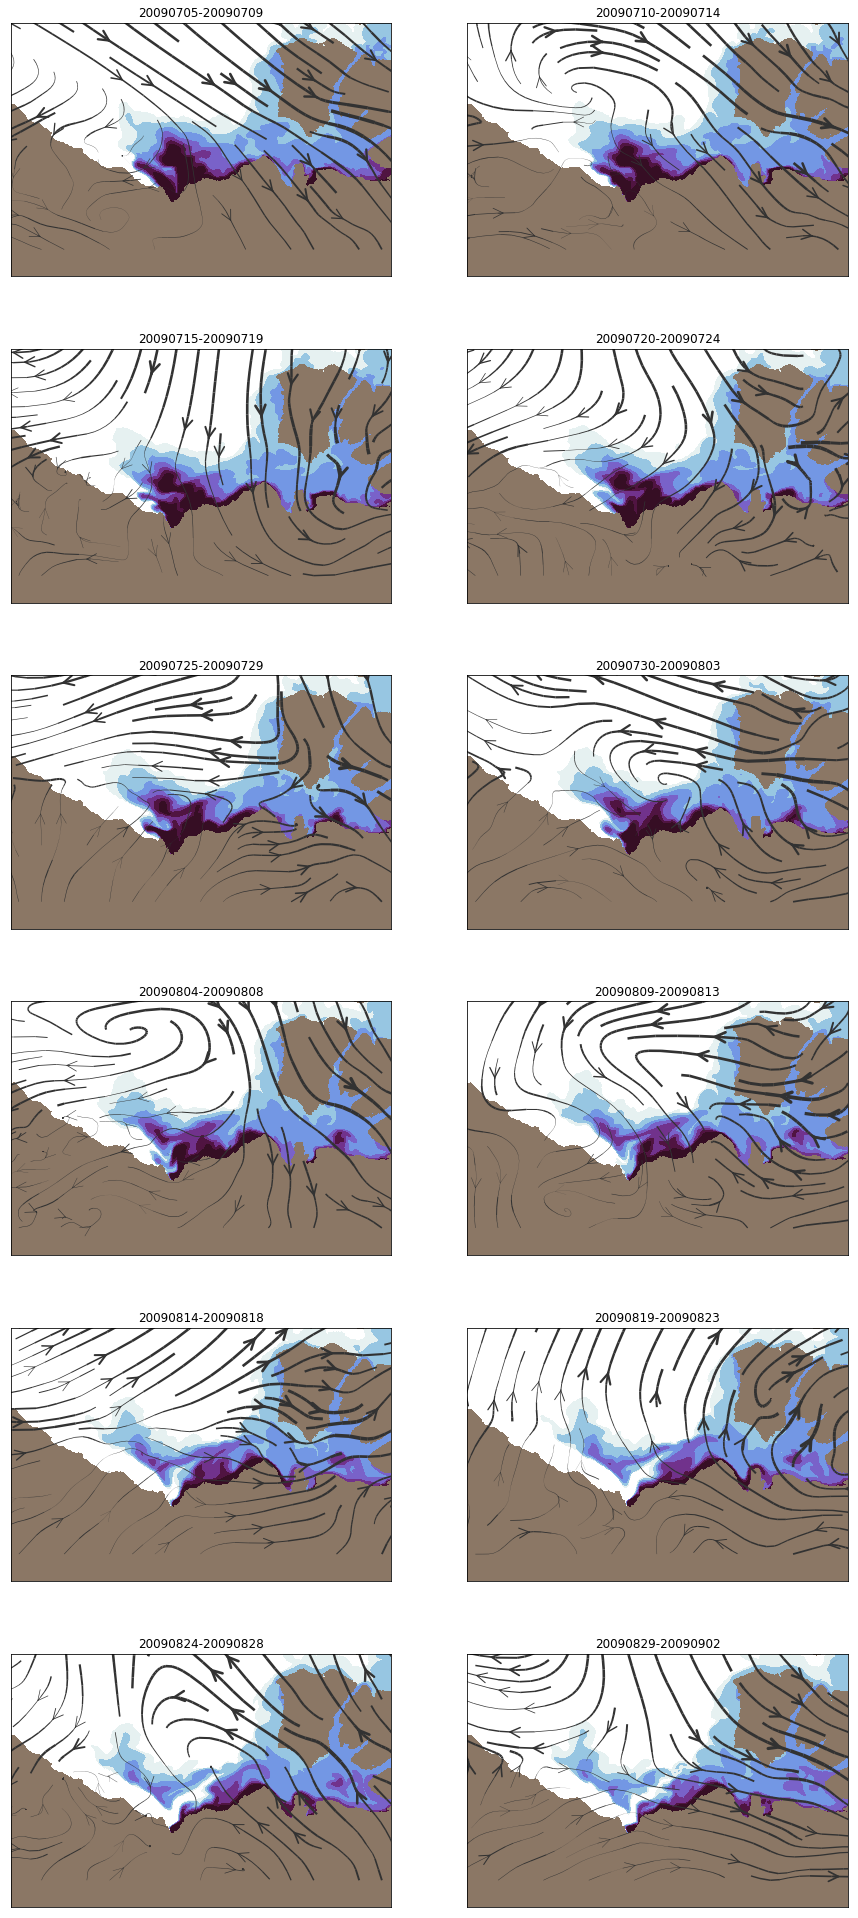

In [131]:
fig, ax = plt.subplots(6,2, figsize=(15,35))

lw=0; time=0; # number of 5day files in time period
for column in [0,1,2,3,4,5]:
    for axis in ax[column,:]:
        lw = plot_5d_mackenzie(axis, continental_contribution_masked_20097[time,:,:], \
                               time, files_ref_20097, overlap_dates_20097, overlap_uwind_20097, \
                               overlap_vwind_20097, wind=True, lw=lw)
            
        time+=1

![title](./woodetal2013.png)

Look at it on a shorter time scale in 2008, like in Fig. 3 of the paper:
- June 1-8
- June 9-16
- June 17-24
- June 25-July 2
- July 3-10
- July 11-18
- July 19-26
- July 27-August 3rd


Compare with wind patterns

In [127]:
#start_date and end_date are datetime objects
start_date_20086 = dt.datetime(2008,6,1)
end_date_20086   = dt.datetime(2008,8,4)

files_ref_20086, files_cont_20086, continental_contribution_20086 \
                                                    = look_river_data(start_date_20086, end_date_20086)
overlap_dates_20086, overlap_uwind_20086, overlap_vwind_20086, \
                               wind_lons, wind_lats = look_wind_data(start_date_20086, end_date_20086)

# ignore areas with less than 1% of continental river contribution to dMn
continental_contribution_masked_20086 = np.ma.masked_where((continental_contribution_20086 < 0.01), \
                                                            continental_contribution_20086)

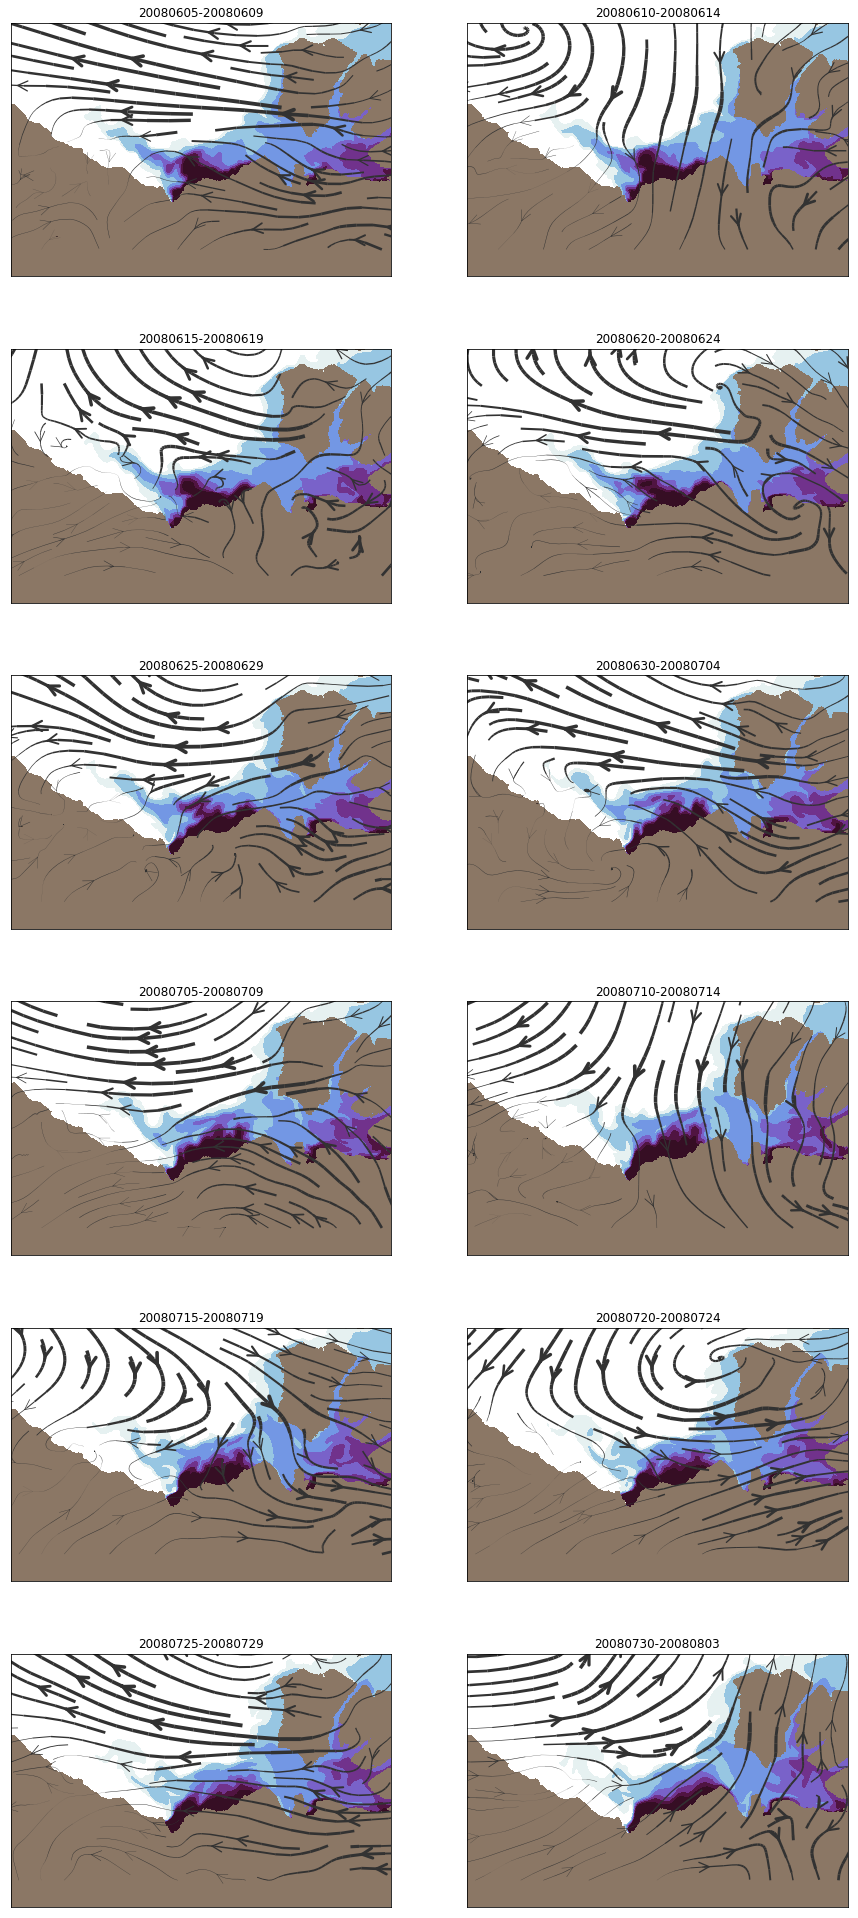

In [129]:
fig, ax = plt.subplots(6,2, figsize=(15,35))

lw=0; time=0; # number of 5day files in time period
for column in [0,1,2,3,4,5]:
    for axis in ax[column,:]:
        lw = plot_5d_mackenzie(axis, continental_contribution_masked_20086[time,:,:], \
                               time, files_ref_20086, overlap_dates_20086, overlap_uwind_20086, \
                               overlap_vwind_20086, wind=True, lw=lw)
            
        time+=1

In [97]:
#start_date and end_date are datetime objects
start_date_20119 = dt.datetime(2011,9,1)
end_date_20119   = dt.datetime(2011,9,30)

files_ref_20119, files_cont_20119, continental_contribution_20119 \
                                         = look_river_data(start_date_20119, end_date_20119)
overlap_dates_20119, overlap_uwind_20119, overlap_vwind_20119, \
                    wind_lons, wind_lats = look_wind_data(start_date_20119, end_date_20119)

# ignore areas with less than 1% of continental river contribution to dMn
continental_contribution_masked_20119 = np.ma.masked_where((continental_contribution_20119 < 0.01), \
                                                            continental_contribution_20119)

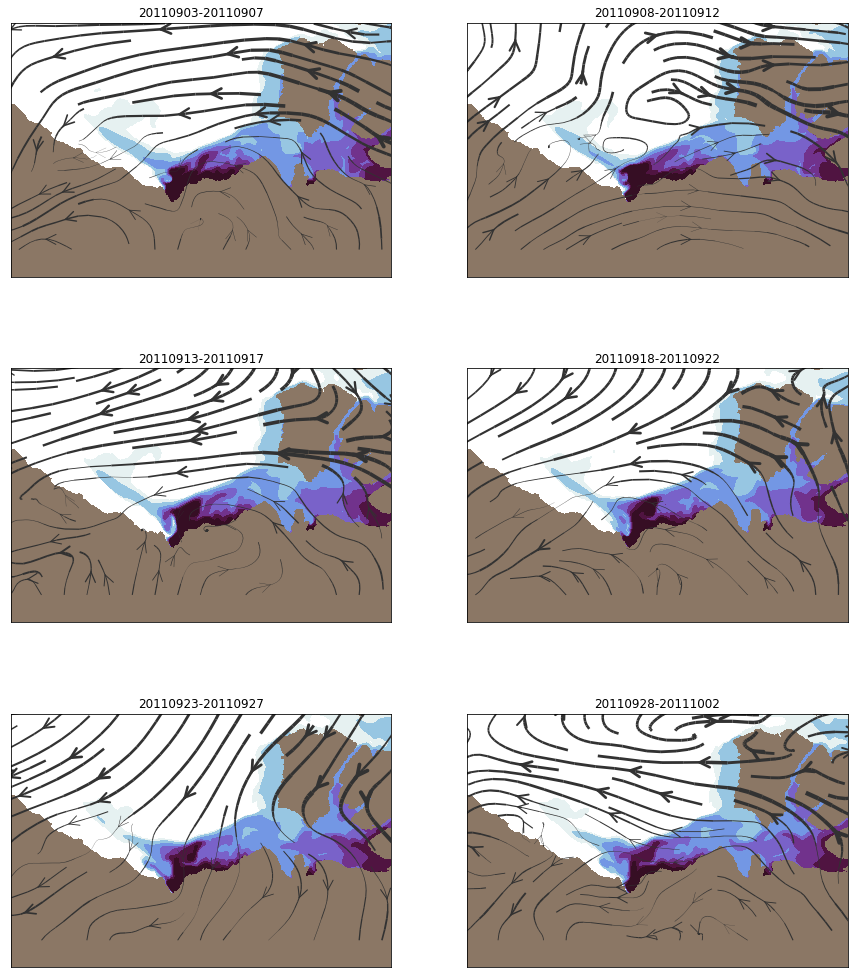

In [99]:
fig, ax = plt.subplots(3,2, figsize=(15,18))

lw=0; time=0; # number of 5day files in time period
for column in [0,1,2]:
    for axis in ax[column,:]:
        lw = plot_5d_mackenzie(axis, continental_contribution_masked_20119[time,:,:], \
                               time, files_ref_20119, overlap_dates_20119, overlap_uwind_20119, \
                               overlap_vwind_20119, wind=True, lw=lw)
            
        time+=1

Time periods to look at based on my animation: (biggest in 2008, 2010, 2016)

- 2007-11/12 
- 2009-11/12
- 2015-11/12

In [106]:
#start_date and end_date are datetime objects
start_date_201512 = dt.datetime(2015,12,1)
end_date_201512   = dt.datetime(2015,12,31)

files_ref_201512, files_cont_201512, continental_contribution_201512 \
                                            = look_river_data(start_date_201512, end_date_201512)
overlap_dates_201512, overlap_uwind_201512, overlap_vwind_201512, \
                       wind_lons, wind_lats = look_wind_data(start_date_201512, end_date_201512)

# ignore areas with less than 1% of continental river contribution to dMn
continental_contribution_masked_201512 = np.ma.masked_where((continental_contribution_201512 < 0.01), \
                                                             continental_contribution_201512)

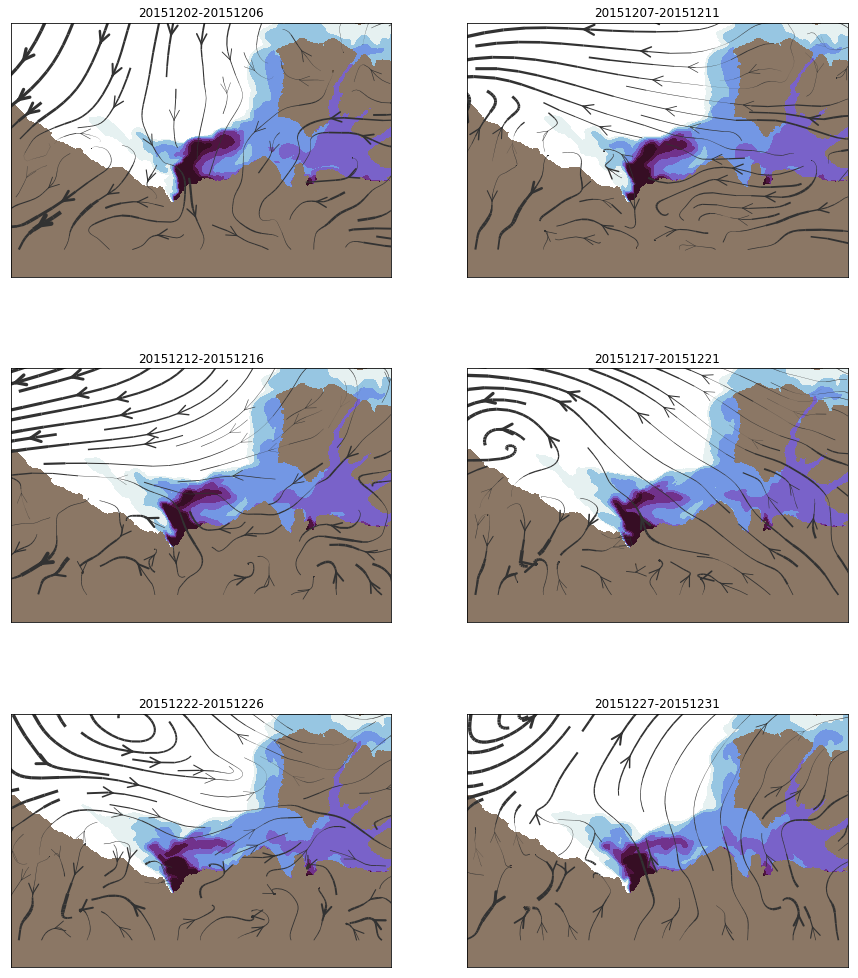

In [108]:
fig, ax = plt.subplots(3,2, figsize=(15,18))

lw=0; time=0; # number of 5day files in time period
for column in [0,1,2]:
    for axis in ax[column,:]:
        lw = plot_5d_mackenzie(axis, continental_contribution_masked_201512[time,:,:], \
                               time, files_ref_201512, overlap_dates_201512, overlap_uwind_201512, \
                               overlap_vwind_201512, wind=True, lw=lw)
            
        time+=1